## Monte Carlo Integration

* A uniquely different approach to integration is the Monte Carlo (MC) method.

### Example: find the area of a circle
* To do this, we define a square, whose area we know, that bounds the circle. So, let the side length of the square equal the diameter of the circle.
* We conceptually *throw darts* randomly at the square. 
* The fraction of the darts that land in the circle multiplied by the area of the square is the area of the circle:
    
    $$A_{circle} = A_{square}\frac{n_{in}}{n_{tot}},$$
where $n_{in}$ is the number of throws that are inside the circle, and $n_{tot}$ is the total number of throws.
    
* A *throw* consists of selecting a random point in the square. We use a random number generator to get a random x location and a random y location. Call these $r_x$ and $r_y$. 
    * The radial distance from the center of the circle of this point is $r_r = \sqrt{r_x^2+r_y^2}$.
    * If $r_r<r$, then the point is inside the circle.
        


In [1]:
using Plots
using Random
using LaTeXStrings
using Polynomials
using CurveFit

In [2]:
r  = 1.0                # circle radius
Asquare = (2*r)^2       # area of square enclosing circle
n  = 100000             # number of tries
rx = rand(n)*2*r .- r   # -1 to 1; x locations
ry = rand(n)*2*r .- r   # -1 to 1; y locations

rr = sqrt.(rx.^2 .+ ry.^2)    # radial location
nhits = length(rr[rr .< r])   # number inside the circle
I = nhits/n * Asquare         # integral of circle

Aexact = pi*r^2
println("A_mc    = $I")
println("A_exact = $Aexact")

A_mc    = 3.14628
A_exact = 3.141592653589793



### Relative Error

* The relative integration error of MC methods scales as 

$$\epsilon_r \propto\frac{1}{\sqrt{n_{tot}}}.$$

* Hence, if you want to decrease your error by a factor of 10, you need to increase the number of throws by a factor of 100.
* If we plot $\log_{10}(\epsilon_r)$ versus $\log_{10}(n_{tot})$, we expect to get a line with slope $-1/2$. This is illustrated below.

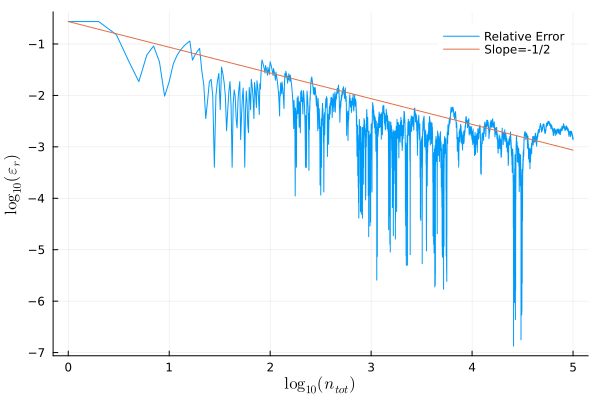

In [3]:
i_n = zeros(n)
i_n[rr .< r] .= 1

itry  = 1:n
Areas = cumsum(i_n)./itry*Asquare
errs  = abs.((Areas.-Aexact)/Aexact)

plot(log10.(itry), log10.(errs), label="Relative Error")
plot!([0,log10(n)], [log10(errs[1]), log10(errs[1])-0.5*log10(n)], label="Slope=-1/2")
plot!(xlabel=L"\log_{10}(n_{tot})")
plot!(ylabel=L"\log_{10}(\epsilon_r)")
plot!(legend_foreground_color=nothing)

### Visual Illustration

In [4]:
r  = 1.0                   # circle radius
As = (2*r).^2              # area of square enclosing circle
n  = 10000                 # number of tries
rx = rand(n)*2*r .- r      # -1 to 1; x locations
ry = rand(n)*2*r .- r      # -1 to 1; y locations
 
rr = sqrt.(rx.^2 + ry.^2); # radial location

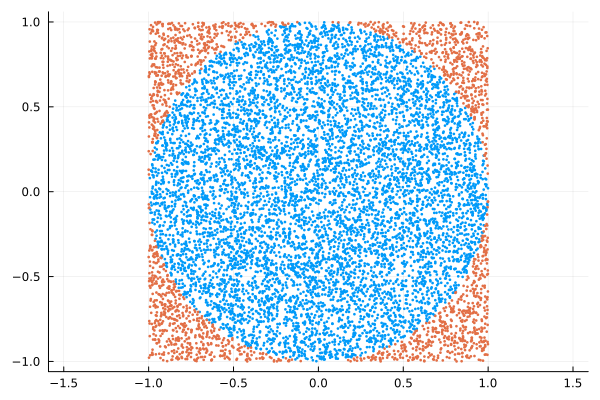

In [5]:
scatter( rx[rr.<r], ry[rr.<r], markersize=1.5, markerstrokewidth=0)
scatter!(rx[rr.>r], ry[rr.>r], markersize=1.5, markerstrokewidth=0)
scatter!(aspect_ratio=:equal)
scatter!(legend=nothing)

### Generic function

* To integrate a generic function:

$$I = \int_a^bf(x)dx,$$

we define a rectagle whose base is $[a,\,b]$, and whose height is larger than the maximum value of $f$ on $[a,\,b]$.

* We through darts in this rectangle by sampling random $(x,\,y)$ points in the rectangle. 
* For each $x$ we evaluate $f(x)$. 
* If $y\le f(x)$, then we call the point a *hit*. 
* The integral is then 

$$I \approx A_{rectangle}\frac{n_{hits}}{n_{tot}}.$$

### Example

* Fit a fifth order polynomial to ten random points. Then integrate this polynomial.

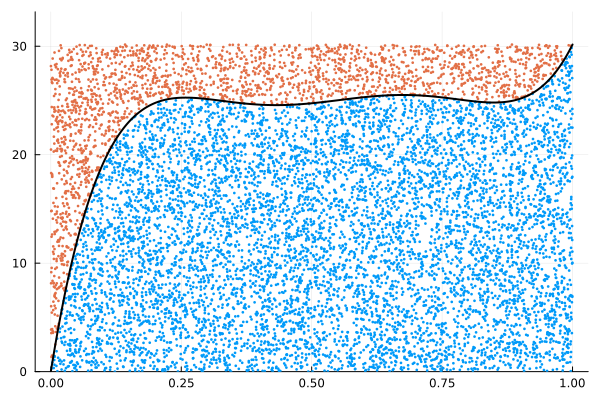

I_mc    = 23.735371322876222
I_exact = 23.61365454467787


In [6]:
x = sort(rand(10))
y = rand(10)
p = poly_fit(x,y,5)
fp = Polynomial(p)
x = LinRange(0,1,1000)
y = fp.(x)
yshift = abs(minimum(y))
y = y .+ yshift


n = 10000
rx = rand(n)
ry = rand(n)*maximum(y)
fx = fp.(rx) .+ yshift

yhit  = ry[ry .<= fx]
xhit  = rx[ry .<= fx]
ymiss = ry[ry .>  fx]
xmiss = rx[ry .>  fx]

scatter( xhit,  yhit,  ms=1.5, markerstrokewidth=0)
scatter!(xmiss, ymiss, ms=1.5, markerstrokewidth=0)
plot!(x,y, lw=2, color="black")
plot!(legend=nothing)
plt=plot!(ylim=[0,1.1*maximum(y)])
display(plt)

Arectangle = 1*maximum(y)
I = Arectangle*length(xhit)/n
Ie = p[6]/6 + p[5]/5 + p[4]/4 + p[3]/3 + p[2]/2 + p[1] + yshift

println("I_mc    = $I")
println("I_exact = $Ie")

### Uses

* Monte Carlo methods are particularly useful for integrating functions in high dimensions.
* For example, in combustion systems we often deal with hundreds of chemical species.
    * In most turbulent simulations, one cannot resolve all of the turbulent flow structures. 
    * These unresolved structures are called *subgrid*.
    * An average value of, say, a reaction rate for a given species in a cell that contains *subgrid* variations is desired. Such an average is computed as
    
    $$\langle\omega_i(\vec{Y})\rangle = \int_{\vec{Y}}P(\vec{Y})\omega_i(\vec{Y})d\vec{Y}.$$
    
    * Here, $\omega_i$ is the reaction rate of species $i$, which is a function of the full chemical state vector $\vec{Y_i}$, which includes all species concentrations, temperature, and pressure. The angle brackets $\langle\cdot\rangle$ denote an average. 
    * $P$ is the multi-dimensional joint probability density function which can be thought of as the fraction of the subgrid volume occupied by a particular value of the chemical state vector (part of the subgrid may be stoichiometric, other parts pure fuel, other parts pure air, etc.).
* The integral is over the full multi-dimensional state space. 
    * If we had 48 species, then with temperature and pressure, we would have a 50 dimensional integral.
* Such an integral cannot be computed using a 50 dimensional grid. Suppose we discretized each dimension with ten points. Then we would have $10^{50}$ total points to evaluate the function at, which is impossible.
* Monte-Carlo methods reduce such calculations to manageable levels.
 